# Implementing the InfoNCE contrastive loss

Welcome fellow friends of artificial intelligence 🦆!

In this notebook, we will implement the SimCLR contrastive loss and test it on the MNIST dataset. We will use a projection head, which we discard at inference time. This notebook accompanies my lecture on contrastive loss, available on [my website](https://maxweissenbacher.netlify.app/).

*Author: Max Weissenbacher (28. Feb. 2024)*


## Loading libraries and data

We start off by loading the libraries and functions we use. No surprises here.

In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, v2, Normalize, RandomHorizontalFlip, RandomResizedCrop
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device {device.type}.")

Using device cuda.


Already we need to make an important choice - the batch size used during training! We choose the batch size small here to ensure the notebook will run on most machines. However, we saw during the lecture that bigger batch sizes are better, so I encourage you to choose the batch size larger if your machine can handle it.

In [4]:
batch_size = 64

First off, we load our dataset and convert it from PIL images to PyTorch tensors. We also normalise the images.

In [5]:
load_transforms = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download MNIST dataset
train_data = MNIST('../../', download=True, train=True, transform=load_transforms)
valid_data = MNIST('../../', download=True, train=False, transform=load_transforms)

# We only use a small subset of the training set to speed up training time
indices = torch.randperm(60000)[:10000]
train_data = torch.utils.data.Subset(train_data, indices)

# Set up the dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

Let's look at the dataset (surprise - it's a bunch of numbers)

In [6]:
def view_tensor_image(x):
    img = x.permute(1,2,0)
    plt.figure(figsize=(2,2))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

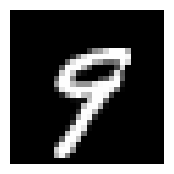

In [7]:
view_tensor_image(train_data[0][0])

## Defining image transforms

A key component of unsupervised contrastive learning are the image augmentations; for each given image we want to produce from it a similar image which represents the same number. Since MNIST images are gray-scale, our options are fairly limited here. We find that flipping horizontally and randomly cropping sections of the image works reasonably well.

In [8]:
contrastive_transform = Compose([
    RandomHorizontalFlip(),
    RandomResizedCrop(size=28, scale=(0.2, 1.), antialias=True),
])

Let's visualise what these image augmentations do! We pick any image from the training set and apply some random transformations to it. Here's what that looks like:

In [9]:
def view_image_transforms(img, transform):
  imgs = torch.stack([transform(img) for i in range(10)], dim=0)
  img_grid = torchvision.utils.make_grid(imgs, nrow=5, normalize=True, pad_value=0.9)
  img_grid = img_grid.permute(1, 2, 0)

  plt.figure(figsize=(10, 5))
  plt.title("Augmented image examples")
  plt.imshow(img_grid)
  plt.axis("off")
  plt.show()

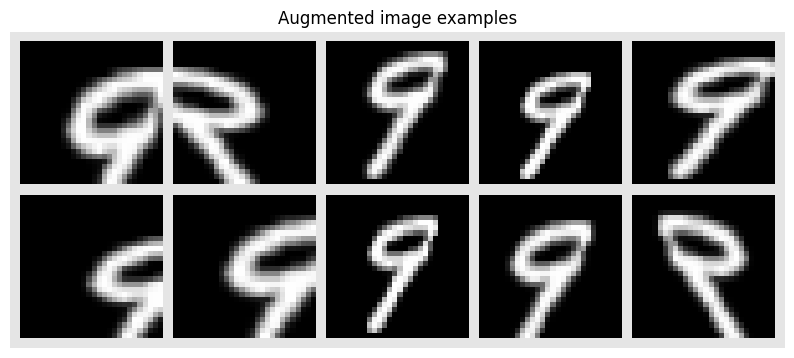

In [17]:
view_image_transforms(train_data[0][0], contrastive_transform)

We are using MNIST in this notebook, but just to give you an idea of what image augmentations might look like for different image datasets, let's take a look at CIFAR10.

We load the dataset and then use AutoAugment to generate a few random augmentations. We are doing this purely for the purpose of understanding how image augmentations work.

In [18]:
cifar_10_load_transforms = Compose([Resize((200,200)), ToTensor()])
cifar10 = CIFAR10(root='../../', train=True, download=True, transform=cifar_10_load_transforms)
cifar10_transforms = v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10)

Files already downloaded and verified


Let's look at what the AutoAugment transform does to images of the CIFAR10 dataset!

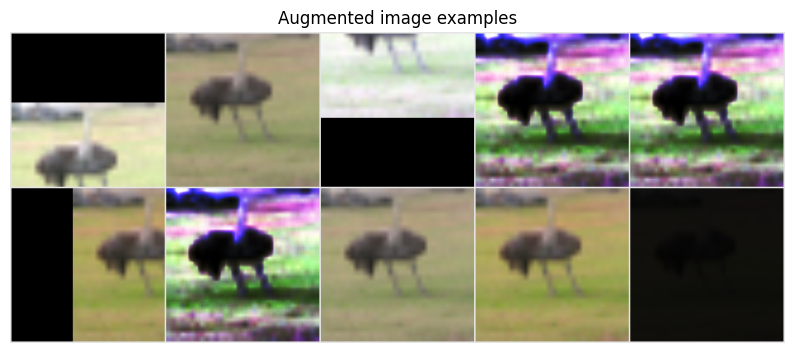

In [24]:
image_idx = 42
view_image_transforms(cifar10[image_idx][0], cifar10_transforms)

### Exercise: Understanding image augmentations

Check out the available PyTorch Vision transforms [here](https://pytorch.org/vision/master/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py). Take a look at what different kinds of transforms you could use. Take a shot at composing your own series of transforms instead of using AutoAugment. For instance, you could try this:

```
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAutocontrast(0.9),
    v2.ColorJitter(brightness=.3, hue=.2),
])
```

Apply these transforms to the CIFAR10 dataset and see what happens!

In [ ]:
# Code your own transforms here and apply them to CIFAR10
# Use the view_image_transforms function from above to visualise your results!

## Coding the InfoNCE loss

Now it's time to code up the contrastive loss we want to use. You can find the definition of the InfoNCE loss in the lecture slides.

We implement the loss here in the following way: the `forward` method receives the model output, `x`, which has shape `[batch size, embedding dimension]` as well as a 'mask'. The mask is a boolean matrix of size `[batch size, batch size]`, where the entry at position `(i,j)` is `True` if sample `i` and sample `j` are positive samples; and False otherwise. We construct this matrix during the training loop and assume it is given to us to compute the loss.

In [ ]:
class InfoNCE(nn.Module):
  def __init__(self, temperature):
    super().__init__()
    self.tau = temperature

  def forward(self, x, positive_mask):
    if not torch.all(positive_mask == positive_mask.transpose(0,1)):
        raise ValueError("positive_mask must be symmetric.")
    if not positive_mask.shape[0] == x.shape[0]:
        raise ValueError("Shape mismatch. positive_mask must be of size batchsize x batch_size.")
    if not len(x.shape) == 2:
        raise ValueError("Shape error. x must be of size 2*batch_size x embedding_dimension.")

    dist = nn.CosineSimilarity(dim=-1)(x[..., None, :, :], x[..., :, None, :])
    dist = torch.exp(dist/self.tau)
    dist = dist / torch.sum(dist, dim=1, keepdim=True)
    dist = -torch.log(dist)
    loss = torch.sum(torch.masked_select(dist, positive_mask))
    loss = loss / (2 * x.shape[0])
    return loss

### Exercise: Make sure you understand the implementation of `InfoNCE`

To understand what's going on, let's decompose the function and execute it step by step. I'll give you some dummy inputs and you copy out each step. Look at the shapes and make sure you know what's happening!

In [ ]:
# Copy out each step of computation in the InfoNCE loss here.
# Like this:

x = torch.randn(5, 10)
positive_mask = torch.zeros((5,5), dtype=torch.bool)

# Go through the steps of computation here:
dist = nn.CosineSimilarity(dim=-1)(x[..., None, :, :], x[..., :, None, :])

# What does dist contain?
print(dist)

tensor([[ 1.0000, -0.3661,  0.1386, -0.0820, -0.1553],
        [-0.3661,  1.0000, -0.3656,  0.2262,  0.0279],
        [ 0.1386, -0.3656,  1.0000, -0.0067,  0.5233],
        [-0.0820,  0.2262, -0.0067,  1.0000, -0.3071],
        [-0.1553,  0.0279,  0.5233, -0.3071,  1.0000]])


## Defining the model

It's time to define our model. Our model will consist of three components:
- An encoder `Enc()`, which maps images to a latent space of dimension 2048
- a projection head `Proj()`, which is a shallow fully connected layer
- a linear layer `Lin()` used only at inference time

The training proceeds in two phases:

First, we compose the encoder with the projection head. This model is trained using our InfoNCE contrastive loss. Once this has been trained, we then discard the projection head and compose the trained encoder with a linear layer. The weights of the linear layer are then trained for a few more epochs using a supervised cross entropy loss.

Let us reiterate this:

In the first step, we train the model

```
model = nn.Sequential(Enc, Proj)
```
using the contrastive loss. In the second step, we *freeze the weights of the encoder* `Enc` and then train the model

```
model = nn.Sequential(Enc, Lin)
```
using a supervised cross entropy loss for a few time steps. This effectively amounts to using the output of the encoder as feature vectors.

Let's define the encoder layer first



In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.2)
            )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.2)
            )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=0.2)
            )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1) # Flatten them for FC
        return x

### Exercise: verify the output size of the encoder

The encoder has an implicitly defined output size. Work out a way to compute that size.

In [ ]:
# Compute the output size of the encoder here and store it in the variable encoder_dim.

Now we define the projection head (a simple shallow MLP). Let's make this an exercise!

### Exercise: Defining the projection head

Define a nn.Module consisting of:
- a linear layer
- a ReLU activation function
- a linear layer

You should map an input of size `[batch size, encoder dimension]` to size `[batch size, 128]`. You worked out the encoder dimension in the previous exercise.

In [ ]:
# Create the projection head here and call it 'projection_head'.

### Spoiler: solution to the above two exercises.

**Quick! Look away!** 😠 Unless you've solved the exercises. In that case, look.

In [ ]:
# Solution to the above two exercises.
encoder = Encoder()
img = train_data[0][0].unsqueeze(0)
print(encoder(img).shape)

encoder_dim = 2048
final_dim = 128

projection_head = nn.Sequential(
    nn.Linear(encoder_dim, encoder_dim),
    nn.ReLU(inplace=True),
    nn.Linear(encoder_dim, final_dim)
    )

torch.Size([1, 2048])


Let's put our model together for training with the contrastive loss!

In [ ]:
encoder = Encoder()
model = nn.Sequential(encoder, projection_head).to(device)

## Training the encoder

We are ready for the first phase of our training! We set up an optimiser, loss function and learning rate scheduler as usual. Finding the right hyperparameters for training is a bit fiddly, so you can just take them as given now.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = InfoNCE(temperature=0.07)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

Before we dive into the training, let's recall how SimCLR works: For each batch of images, we first compute two augmentations of each image (thereby doubling the batch size effectively). Within this batch, these two images are considered to be positive samples of one another, and all other images are considered to be negative samples.

Let's look at how we're going to do this during train time. We start by getting a batch of images from our dataloader.

In [ ]:
for i, data in enumerate(train_loader):
  # Get only the first batch
  if i > 0:
    break
# Extract the images from our data, we don't need the labels now
images, labels = data
# Map to the right device
images = images.to(device)


Now that we have a batch of images, let's compute two augmentations of each image and stack the resulting vectors together.

In [ ]:
# For each image, compute two augmented versions of it
img_augmented_1 = contrastive_transform(images)
img_augmented_2 = contrastive_transform(images)

print(f"img_augmented_1 has shape {img_augmented_1.shape}")
print(f"img_augmented_2 has shape {img_augmented_2.shape}")

# Stack everything together into a bigger tensor
img_augmented_combined = torch.vstack([img_augmented_1, img_augmented_2])

print(f"img_augmented_combined has shape {img_augmented_combined.shape}")

img_augmented_1 has shape torch.Size([64, 1, 28, 28])
img_augmented_2 has shape torch.Size([64, 1, 28, 28])
img_augmented_combined has shape torch.Size([128, 1, 28, 28])


Great! We can now map this through our model. After this, the only thing missing to compute the loss value is the `positive_mask` argument. Because of the way we stacked the images, we need to set the value of the mask at indices `(i, i+64)` and `(64+i, i)` to True! These are the pairs of augmented images arising from the same original image in the dataset.

In [ ]:
batch_size = images.shape[0]

positive_mask = torch.zeros((2*batch_size,2*batch_size), dtype=torch.bool, device=device)
for i in range(batch_size):
  positive_mask[i,batch_size+i] = True
  positive_mask[batch_size+i,i] = True

### Exercise: Inspect the positive_mask tensor.

Look at `positive_mask` and understand why each entry is `True` or `False`.

Finally, we are ready to build our training loop and train the model! Phew! 🙃

*Note: if you have access to a GPU, this should take < 4s per epoch. On a CPU it might take around 40s per epoch.*

In [ ]:
num_epochs = 100
losses = []

pbar = tqdm(range(num_epochs))
for _ in pbar:
  avg_loss = []  # average loss across batches
  avg_gn = []  # average gradient norm across batches

  # Iterate over all data to update parameters
  for data in train_loader:
    # We only use the images for training, not the labels!
    images, labels = data
    images = images.to(device)

    batch_size = images.shape[0]

    # For each image, compute two augmented versions of it
    img_augmented_1 = contrastive_transform(images)
    img_augmented_2 = contrastive_transform(images)

    # Stack the results together
    img_augmented_combined = torch.vstack([img_augmented_1, img_augmented_2])

    # Compute the mask needed for the contrastive loss
    # The aim here is to set those entries to True which correspond to
    # augmentations of the same image.
    positive_mask = torch.zeros((2*batch_size,2*batch_size), dtype=torch.bool, device=device)
    for i in range(batch_size):
      positive_mask[i,batch_size+i] = True
      positive_mask[batch_size+i,i] = True

    # Map through the model
    output = model.forward(img_augmented_combined)

    # Compute the contrastive loss
    loss = criterion(output, positive_mask)

    # Take optimiser steps and clip gradient norm
    optimizer.zero_grad()
    loss.backward()
    gn = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()

    # Remember loss and gradient norm per batch
    avg_loss.append(loss.detach().item())
    avg_gn.append(gn.detach().item())

  # Update progress bar
  description = (
      f'Loss {np.array(avg_loss).mean():.2f} | '
      f'grad norm {np.array(avg_gn).mean():.2f} | '
      f'learning rate {optimizer.param_groups[0]["lr"]:.9f}'
  )
  pbar.set_description(description)

  # Logging
  losses.append(np.array(avg_loss).mean())

  # Update learning rate
  scheduler.step()

Loss 1.45 | grad norm 4.35 | learning rate 0.006561000: 100%|██████████| 100/100 [06:39<00:00,  4.00s/it]


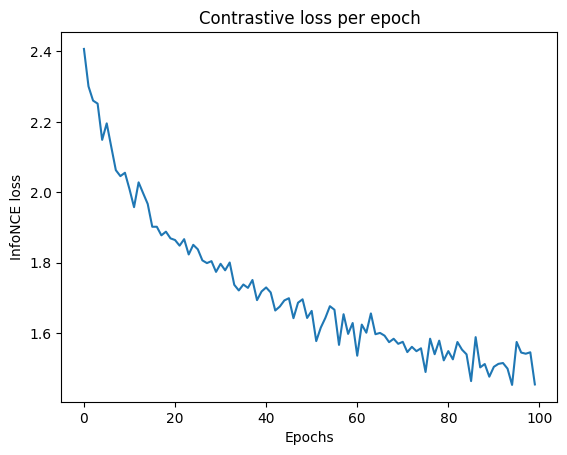

In [ ]:
plt.plot(losses)
plt.title("Contrastive loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("InfoNCE loss")
plt.show()

## Inference: fine-tuning a final linear layer

Now that our encoder is trained, we will freeze its weights and compose it with a final linear and softmax layer. We then train the weights of the linear inference layer for a few epochs and look at the model's accuracy!

In [ ]:
linear = nn.Linear(in_features=encoder_dim, out_features=10, device=device)
softmax = nn.Softmax(dim=-1)

# Compose the encoder with the final linear and softmax layer
inference_model = nn.Sequential(model[0], linear, softmax).to(device)

# Set required_grad to False for the encoder layer, so that only the linear layer gets trained.
for layer in inference_model[0].parameters():
  layer.requires_grad=False

# Set up cross entropy loss and optimiser
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(inference_model[1].parameters(), lr=1e-2)

Let us also define a utility function to compute the model's accuracy here.

In [ ]:
def accuracy(dataloader, model):
  """Top-1 accuracy"""
  num_samples = 0
  num_correct = 0

  for i, data in enumerate(dataloader):
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
      output = model(images)
    _, inds = torch.topk(output, 1)
    num_correct += int(torch.sum(labels == inds.flatten()))
    num_samples += len(labels)

  return num_correct / num_samples

Now we can train the inference model. We also periodically evaluate the accuracy of the model on the testing set to see how many training steps we really need.

In [ ]:
losses = []
accuracies = []
pbar = tqdm(range(50))

for epoch in pbar:
  avg_loss = []  # average loss across batches
  for i, data in enumerate(train_loader):
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    output = inference_model(images)
    loss = cross_entropy_loss(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss.append(loss.detach().item())

  # Evaluate the model every 10 epochs on the test set
  if epoch % 10 == 0:
    accuracies.append(accuracy(valid_loader, inference_model))

  # Update progress bar
  description = (
    f'Loss {np.array(avg_loss).mean():.2f} | '
    #f'grad norm {np.array(avg_gn).mean():.2f} | '
    f'learning rate {optimizer.param_groups[0]["lr"]:.9f}'
  )
  pbar.set_description(description)
  losses.append(np.array(avg_loss).mean())

Loss 1.61 | learning rate 0.010000000: 100%|██████████| 50/50 [02:25<00:00,  2.91s/it]


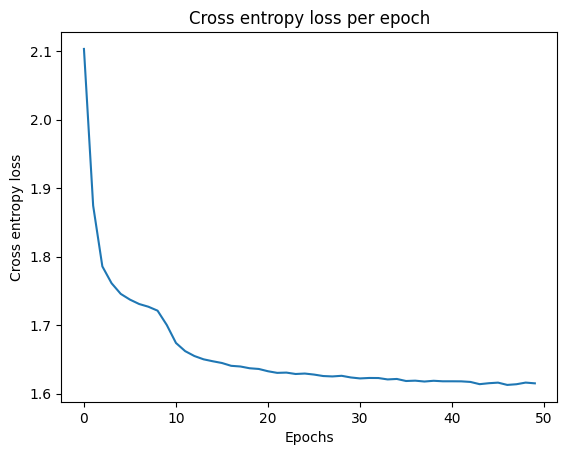

In [ ]:
plt.plot(losses)
plt.title("Cross entropy loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Cross entropy loss")
plt.show()

Let's look at the final accuracy of our trained inference model.

In [ ]:
acc = accuracy(valid_loader, inference_model)
print(f"Final test set (top-1) accuracy {100*acc:.2f}%.")

Final test set (top-1) accuracy 86.10%.


Not bad! But let's look at the accuracy on the test set as a function of the number of epochs. We evaluated the model on the test set every 10 epochs. The plot below reveals that only very few epochs of 'fine-tuning' are necessary to reach final performance!

This is thanks to the features we learned with the contrastive loss - a simple linear inference layer manages to get good accuracy within a few epochs of training.

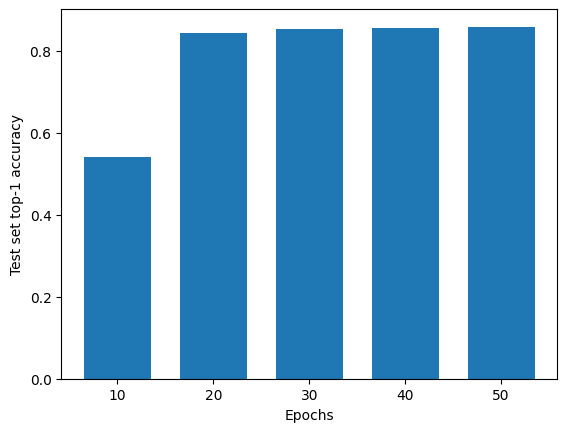

In [ ]:
plt.bar(10*np.arange(len(accuracies)), accuracies, width=7.)
plt.xlabel('Epochs')
plt.ylabel('Test set top-1 accuracy')
plt.xticks(10*np.arange(len(accuracies)), 10*np.arange(1,len(accuracies)+1))
plt.show()

## Final thoughts

- Keep in mind that we only used 1/6th of the training dataset (in order to make the notebook run faster). Performance is likely to increase if you use the entire training set.
- Training a contrastive loss on other image datasets is a little bit trickier and requires a careful choice of model architecture, as well as other hyperparameters. But the basic ideas are the same.
- I hope you had fun! 🎉

## References

- The original [SimCLR paper](https://arxiv.org/abs/2002.05709)
- The Encoder architecture is borrowed from [giakou4's Github](https://github.com/giakou4/classification/tree/main).